# Variational Autoencoder (VAE)

Useful links: 
* original paper http://arxiv.org/abs/1312.6114
* helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this seminalr we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [1]:
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset()


In [2]:
import numpy as np
X_train = data[:10000].reshape((10000,-1))
print(X_train.shape)
X_val = data[10000:].reshape((-1,X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [3]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

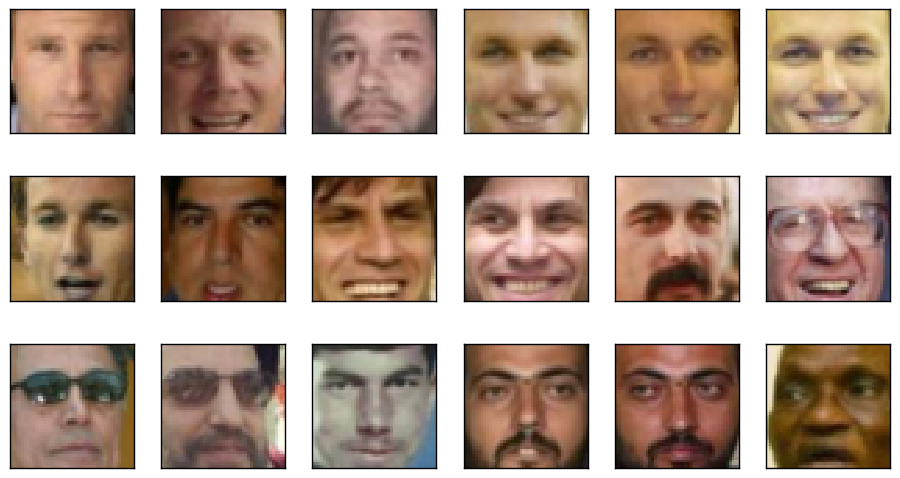

In [5]:
plot_gallery(X_train, image_h, image_w)

In [6]:
import theano
import theano.tensor as T

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 3: Tesla K20m (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)


# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [122]:
import lasagne
from lasagne.layers import InputLayer, DenseLayer
from lasagne.nonlinearities import rectify, sigmoid

input_X = T.matrix("X")

input_shape = [None,image_h*image_w*3]

In [123]:
HU_encoder = 2048 #you can play with this values
HU_decoder = 2048
dimZ = 512 #considering face reconstruction task, which size of representation seems reasonable?

# define the network
# use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# zero initialization for biases
# it's also convenient to put sigmoid activation on output layer to get nice normalized pics

l_input = InputLayer(input_shape, input_var=input_X)
l_enc = DenseLayer(l_input, num_units=HU_encoder, nonlinearity=rectify)
l_z = DenseLayer(l_enc, num_units=dimZ, nonlinearity=sigmoid)
l_dec = DenseLayer(l_z, num_units=HU_decoder, nonlinearity=rectify)
l_out = DenseLayer(l_dec, num_units=input_shape[1], nonlinearity=sigmoid)

In [124]:
# create prediction variable
prediction = lasagne.layers.get_output(l_out)
z_pediction = lasagne.layers.get_output(l_z)

# create loss function
loss = lasagne.objectives.squared_error(prediction, input_X).mean()

# create parameter update expressions
params = lasagne.layers.get_all_params(l_out, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=0.001)

# compile training function that updates parameters and returns training loss
# this will take a while
train_fn = theano.function([input_X], loss, updates=updates)
test_fn = theano.function([input_X], prediction)
get_z_prediction = theano.function([input_X], z_pediction)

In [125]:
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

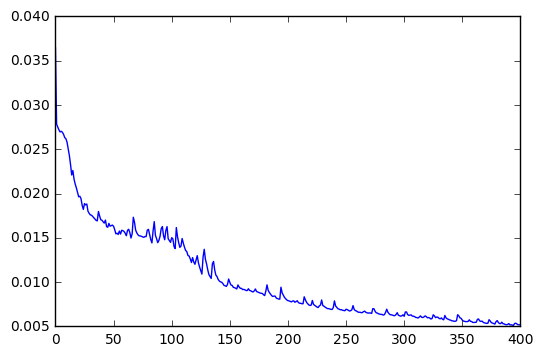

In [126]:
from tqdm import tqdm
from IPython.display import clear_output

N_EPOCH = 400
BATCH_SIZE = 2048

losses = {}
for i in range(N_EPOCH):
    print("epoch {}".format(i))
    
    train_losses = []
    for batch in tqdm(iterate_minibatches(X_train, BATCH_SIZE)):
        train_losses.append(train_fn(batch))
    losses[i] = np.mean(train_losses)
            
    clear_output(True)
    plt.plot(*zip(*sorted(losses.items(),key=lambda t: t[0])))
    plt.show()

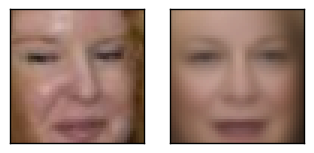

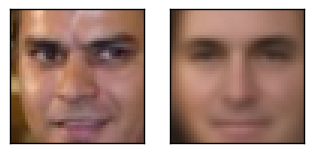

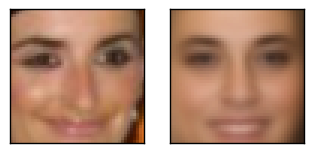

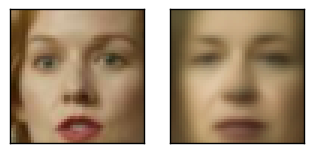

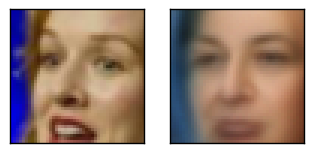

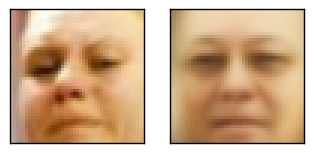

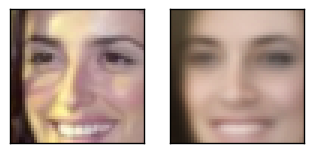

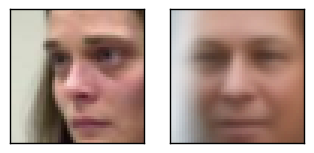

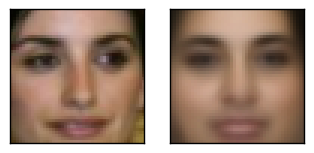

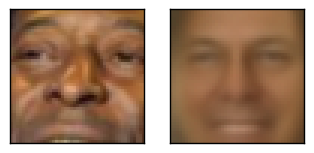

In [127]:
for batch in iterate_minibatches(X_val[:10], 1):
    pred = test_fn(batch)
    plot_gallery([batch[0],pred], image_h, image_w, n_row=1, n_col=2)

# Sampling

This task requires deeper Lasagne knowledge. You need to perform inference from $z$, reconstruct an image given some random $z$ representations.

In [128]:
z_sample = T.matrix()

l_input2 = InputLayer((None,) + (dimZ,), input_var=z_sample)
l_dec2 = DenseLayer(l_input2, num_units=HU_decoder, nonlinearity=rectify, W=l_dec.W, b=l_dec.b)
l_out2 = DenseLayer(l_dec2, num_units=input_shape[1], nonlinearity=sigmoid, W=l_out.W, b=l_out.b)

# Your code goes here:
generated_x = lasagne.layers.get_output(l_out2)

gen_fn = theano.function([z_sample], generated_x)

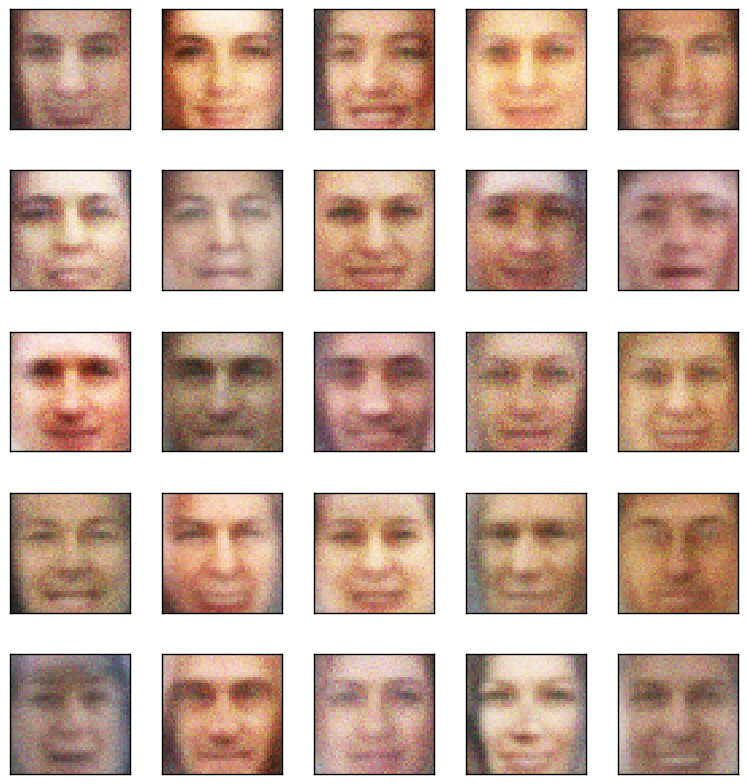

In [129]:
z = np.random.randn(25, dimZ)*0.5
output = gen_fn(np.asarray(z, dtype=theano.config.floatX))
plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

Can you visualize how the distribution of $z$ looks like? Is it dense? What properties would we expect from it? Can we perform interpolation in $z$ space?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution q(z|x). Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick is implemented via the **GaussianSampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon$

The code for this layer taken from "recipes" folder of Lasagne github repo:

In [12]:
import GS

#reload(GS)

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average like it is in Lasagne recipes.

In [97]:
from lasagne.nonlinearities import tanh, softplus
from GS import GaussianSampleLayer

# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before

HU_encoder = 2048
HU_decoder = 2048
dimZ = 512

# define the network
# you can start from https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# or another example https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

input_X = T.matrix("X")

l_input = InputLayer(input_shape, input_var=input_X)
l_enc_hid = DenseLayer(l_input, num_units=HU_encoder, nonlinearity=tanh)
l_enc_mu = DenseLayer(l_enc_hid, num_units=dimZ, nonlinearity=None)
l_enc_logsigma = DenseLayer(l_enc_hid, num_units=dimZ, nonlinearity=None)
l_Z = GaussianSampleLayer(l_enc_mu, l_enc_logsigma)
l_dec_hid = DenseLayer(l_Z, num_units=HU_decoder, nonlinearity=tanh)

#l_output = DenseLayer(l_dec_hid, num_units=input_shape[1], nonlinearity=sigmoid)

l_dec_mu = DenseLayer(l_dec_hid, num_units=input_shape[1], nonlinearity=None)
# relu_shift is for numerical stability - if training data has any
# dimensions where stdev=0, allowing logsigma to approach -inf
# will cause the loss function to become NAN. So we set the limit
# stdev >= exp(-1 * relu_shift)
relu_shift = 10
l_dec_logsigma = DenseLayer(l_dec_hid, num_units=input_shape[1], nonlinearity = lambda a: T.nnet.relu(a + relu_shift) - relu_shift)
l_output = GaussianSampleLayer(l_dec_mu, l_dec_logsigma)

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = \frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

$\sigma >= 0$. $\log\sigma$ может быть любым. Его удобно задать слоем без нелинейности.

In [98]:
def KL_divergence(mu, logsigma):
    return T.mean(1/2 * T.sum(-1 - 2*logsigma + mu**2 + T.exp(2*logsigma),axis=0))

def mse(x, dec_x):
    return T.mean(lasagne.objectives.squared_error(dec_x, x))

def log_likelihood(x, mu, logsigma):
    return T.mean(T.sum(-logsigma - (mu - x)**2 / (2 * T.exp(logsigma * 2)), axis=0))

In [99]:
lasagne.layers.get_all_layers(l_output) # should be ~9 layers total

Now build the loss and training function:

In [117]:
# create prediction variable
prediction = lasagne.layers.get_output(l_output)
vae_z_prediction = lasagne.layers.get_output(l_Z)

# create loss function
# ...
#loss = KL_divergence(lasagne.layers.get_output(l_enc_mu), lasagne.layers.get_output(l_enc_logsigma)) + mse(input_X, prediction)

loss = KL_divergence(lasagne.layers.get_output(l_enc_mu), lasagne.layers.get_output(l_enc_logsigma)) - \
log_likelihood(input_X, lasagne.layers.get_output(l_dec_mu), lasagne.layers.get_output(l_dec_logsigma)) 


# create parameter update expressions
params = lasagne.layers.get_all_params(l_output, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=0.00001)

# compile training and testing functions
train_fn = theano.function([input_X], loss, updates=updates)
test_fn = theano.function([input_X], prediction)
get_vae_z_prediction = theano.function([input_X], vae_z_prediction)

In [118]:
z_sample = T.matrix()

l_input2 = InputLayer((None,) + (dimZ,), input_var=z_sample)
l_dec_hid2 = DenseLayer(l_input2, num_units=HU_decoder, nonlinearity=tanh, W=l_dec_hid.W, b=l_dec_hid.b)

#l_output2 = DenseLayer(l_dec_hid2, num_units=input_shape[1], nonlinearity=sigmoid, W=l_output.W, b=l_output.b)

l_dec_mu2 = DenseLayer(l_dec_hid2, num_units=input_shape[1], nonlinearity=None, W=l_dec_mu.W, b=l_dec_mu.b)
l_dec_logsigma2 = DenseLayer(l_dec_hid2, num_units=input_shape[1], nonlinearity = lambda a: T.nnet.relu(a + relu_shift) - relu_shift, W=l_dec_logsigma.W, b=l_dec_logsigma.b)
l_output2 = GaussianSampleLayer(l_dec_mu2, l_dec_logsigma2)

# Your code goes here:
vae_generated_x = lasagne.layers.get_output(l_output2)

vae_gen_fn = theano.function([z_sample], vae_generated_x)

And train the model:

In [120]:
N_EPOCH = 25000
BATCH_SIZE = 2048

losses = {}
for i in range(N_EPOCH):
    print("epoch {}".format(i))
    
    train_losses = []
    for batch in tqdm(iterate_minibatches(X_train, BATCH_SIZE)):
        train_losses.append(train_fn(batch))
    losses[i] = np.mean(train_losses)
            
    clear_output(True)
    plt.plot(*zip(*sorted(losses.items(),key=lambda t: t[0])))
    plt.show()

KeyboardInterrupt: 

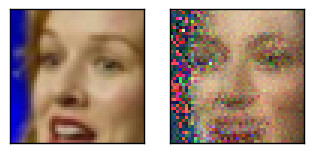

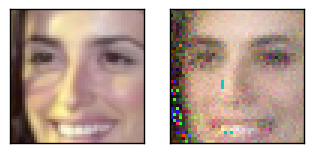

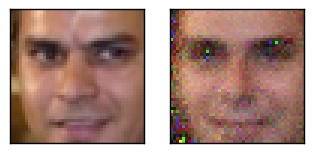

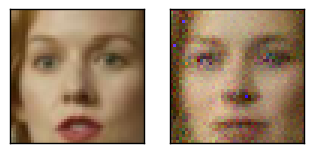

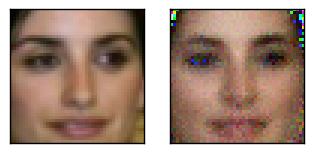

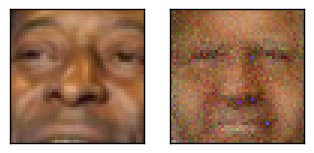

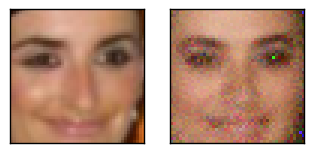

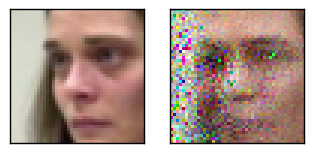

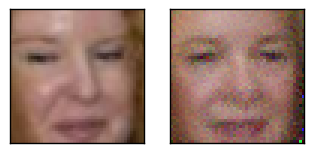

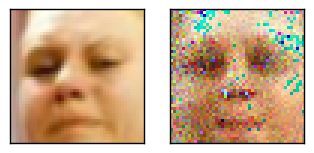

In [121]:
for batch in iterate_minibatches(X_val[:10], 1):
    pred = test_fn(batch)
    plot_gallery([batch[0],pred], image_h, image_w, n_row=1, n_col=2)

# Congrats!

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" column as a separate numpy vector and sort this vector.

In [130]:
sorted_attrs = attrs['Smiling'].sort_values(inplace=False, ascending=False)

n_img = 10

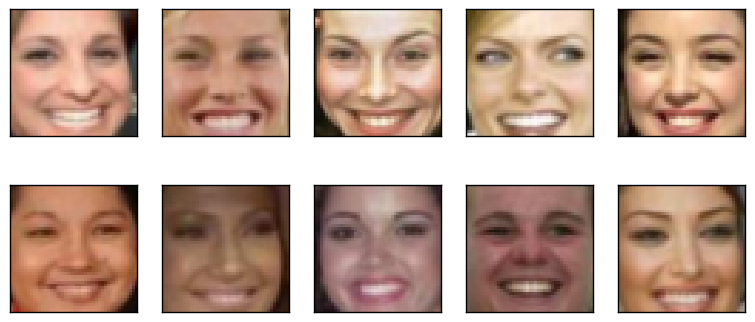

In [131]:
top10_idx = sorted_attrs[:n_img].index
smile = data[top10_idx, :]
plot_gallery(smile, image_h, image_w, 2, 5)

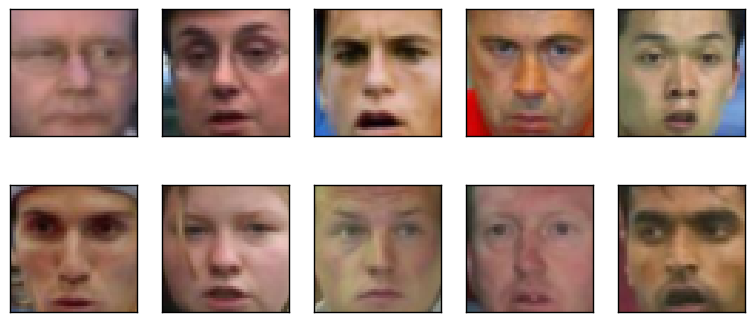

In [132]:
last10_idx = sorted_attrs[-n_img:].index
not_smile = data[last10_idx, :]
plot_gallery(not_smile, image_h, image_w, 2, 5)

not_smile = np.float32(not_smile.reshape((not_smile.shape[0], -1))) / 255

2) Take z-representations of those top images (you can do it only for positive or for both) and average them to find **"vector representation"** of the attribute.

3) Show how **"feature arithmetics"** works with representations of both VAE and conventional autoencoder. Show how to generate an image with preconditioned attribute. Take some sad faces and make them smiling.

4) (If you didn't manage to tune VAE, just show if it works for just AE.) Discuss the results.

In [133]:
all_smile_idx = sorted_attrs[sorted_attrs > 0].index
all_smile = np.float32(data[all_smile_idx, :].reshape((all_smile_idx.shape[0], -1))) / 255

all_not_smile_idx = sorted_attrs[sorted_attrs < 0].index
all_not_smile = np.float32(data[all_not_smile_idx, :].reshape((all_not_smile_idx.shape[0], -1))) / 255

# Autoencoder

In [134]:
smile_z_mean = get_z_prediction(all_smile).mean(axis=0)
not_smile_z_mean = get_z_prediction(all_not_smile).mean(axis=0)

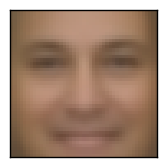

In [135]:
output = gen_fn(np.asarray(smile_z_mean.reshape(1, -1), dtype=theano.config.floatX))
plot_gallery(output, image_h, image_w, n_row=1, n_col=1)

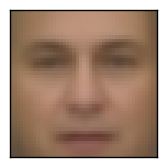

In [136]:
output = gen_fn(np.asarray(not_smile_z_mean.reshape(1, -1), dtype=theano.config.floatX))
plot_gallery(output, image_h, image_w, n_row=1, n_col=1)

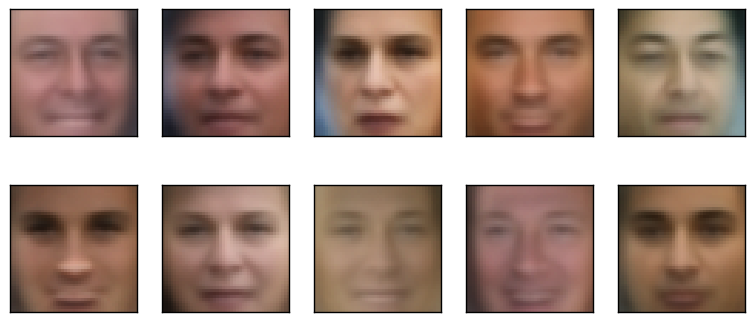

In [137]:
not_smile_to_smile = get_z_prediction(not_smile) - not_smile_z_mean + smile_z_mean
output = gen_fn(np.asarray(not_smile_to_smile, dtype=theano.config.floatX))
plot_gallery(output, image_h, image_w, n_row=2, n_col=5)

# VAE

In [138]:
smile_z_mean = get_vae_z_prediction(all_smile).mean(axis=0)
not_smile_z_mean = get_vae_z_prediction(all_not_smile).mean(axis=0)

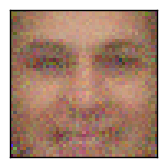

In [139]:
output = vae_gen_fn(np.asarray(smile_z_mean.reshape(1, -1), dtype=theano.config.floatX))
plot_gallery(output, image_h, image_w, n_row=1, n_col=1)

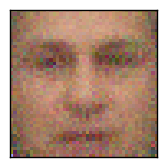

In [140]:
output = vae_gen_fn(np.asarray(not_smile_z_mean.reshape(1, -1), dtype=theano.config.floatX))
plot_gallery(output, image_h, image_w, n_row=1, n_col=1)

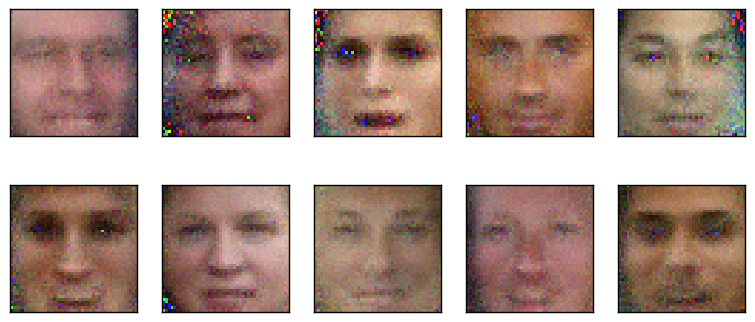

In [141]:
not_smile_to_smile = get_vae_z_prediction(not_smile) - not_smile_z_mean + smile_z_mean
output = vae_gen_fn(np.asarray(not_smile_to_smile, dtype=theano.config.floatX))
plot_gallery(output, image_h, image_w, n_row=2, n_col=5)

<img src="linear.png" alt="linear">